In [1]:
# from EDA
import dowhy
import dowhy.datasets, dowhy.plotter
from dowhy import CausalModel
from dowhy import causal_estimators
import seaborn as sns
import graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import Image, display
from utility_functions import *

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

from numpy import mean
from numpy import std
from numpy.random import randn
from numpy.random import seed
from matplotlib import pyplot

In [2]:
# import necessary packages
import warnings
warnings.filterwarnings('ignore')

import dowhy
from dowhy import CausalModel

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from numpy.random import normal

In [3]:
df = pd.read_csv('lucas0_train.csv')
df.head()

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1


In [9]:
nodes = list(df.columns)
target_node = 'Lung_cancer'
edges_list = [('Anxiety','Smoking'), ('Peer_Pressure','Smoking'), ('Smoking','Yellow_Fingers'), ('Smoking','Lung_cancer'), 
                  ('Genetics','Lung_cancer'), ('Genetics','Attention_Disorder'), ('Allergy','Coughing'), 
              ('Lung_cancer','Coughing'),('Lung_cancer','Fatigue'), ('Coughing','Fatigue'),('Fatigue','Car_Accident'), 
              ('Attention_Disorder','Car_Accident')]

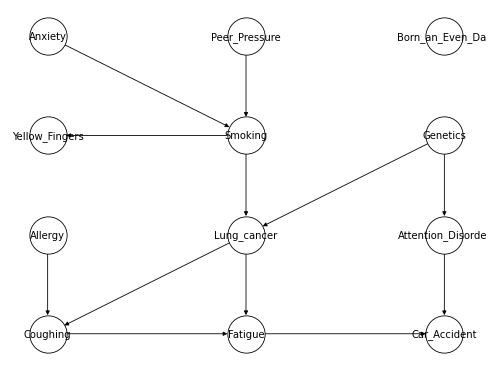

In [14]:
G = nx.DiGraph(directed=True)
G.add_nodes_from(nodes)
G.add_edges_from(edges_list)

pos = {'Anxiety': (-1, 1), 'Peer_Pressure': (0, 1), 'Born_an_Even_Day': (1, 1), 
       'Yellow_Fingers': (-1, 0), 'Smoking': (0, 0),'Genetics': (1, 0), 
       'Allergy': (-1, -1), 'Lung_cancer': (0, -1),'Attention_Disorder': (1, -1),
      'Coughing': (-1, -2), 'Fatigue': (0, -2), 'Car_Accident': (1, -2)}

# color_map = ['yellow' if node == target_node else 'w' for node in G]

fig = plt.figure(1, figsize=(8, 6), dpi=60)
nx.draw(G, pos = position, with_labels=True, node_size=2000, node_color='w', edgecolors ='black')
nx.write_gml(G, "causal_graph_part_5.gml")

# Causal Discovery
- forward step;
- backward step. 

### 1. Forward step

In [15]:
import ges

data = df.to_numpy()
print(data)

[[0 0 1 ... 1 0 0]
 [0 1 0 ... 0 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 0 ... 0 0 1]
 [1 1 1 ... 0 1 1]
 [1 1 0 ... 1 1 1]]


In [16]:
def get_colors(G):
    edges = G.edges()
    for (x, y) in G.edges():
        if (y, x) in edges:
            # bi-directional edge
            nx.set_edge_attributes(G, {(x, y): {"directed": False}})
        else:
            nx.set_edge_attributes(G, {(x, y): {"directed": True}})
    colors = ['black' if G[u][v]['directed']==True else 'r' for u,v in G.edges()]
    return colors

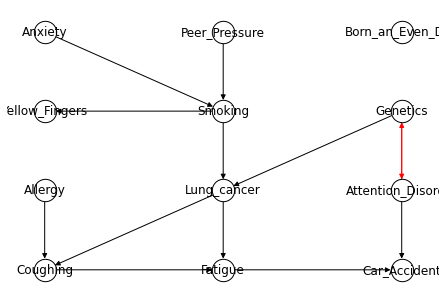

In [19]:
estimate, score = ges.fit_bic(data, phases=['forward', 'backward'], debug=0) # debug 0-4 prints different results
H = nx.DiGraph()
H = nx.from_numpy_array(estimate, create_using=nx.DiGraph)
mapping = dict(zip(H.nodes, nodes))
H = nx.relabel_nodes(H, mapping)
colors = get_colors(H)

nx.draw(H, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

Now, we look at the learning process step-by-step. 
We first initalize a Gaussian BIC score object. This object will pre-compute and cache l0-penalized gaussian likelihood scores. By default, we use the 'scatter' method and the empirical covariance matrix to compute the likelihood.

In [20]:
from ges.scores.gauss_obs_l0_pen import GaussObsL0Pen
# initalize the Gaussian BIC score
cache = GaussObsL0Pen(data)
print(cache._scatter)

[[ 0.18624375  0.138045    0.08354875  0.03052125  0.00152625  0.00081875
  -0.00484875  0.0099425   0.0309075   0.0073925   0.05187375  0.09507125]
 [ 0.138045    0.170476    0.061449    0.022447   -0.000589    0.001305
  -0.001289    0.009114    0.022666    0.009274    0.039209    0.069787  ]
 [ 0.08354875  0.061449    0.23296975  0.00068425  0.00104525 -0.00333625
  -0.00912975  0.0066485   0.0108215   0.0042385   0.03033475  0.04109425]
 [ 0.03052125  0.022447    0.00068425  0.22487775  0.00336075  0.00336625
  -0.00166425  0.0050955   0.0058145  -0.0011345   0.01077925  0.01210775]
 [ 0.00152625 -0.000589    0.00104525  0.00336075  0.12003975  0.04351125
  -0.00378525  0.0226415   0.0151885  -0.0013485   0.02178025  0.03535075]
 [ 0.00081875  0.001305   -0.00333625  0.00336625  0.04351125  0.21849375
  -0.00486375  0.0633325   0.0068175   0.0043825   0.01158875  0.01431625]
 [-0.00484875 -0.001289   -0.00912975 -0.00166425 -0.00378525 -0.00486375
   0.24988975 -0.0069085  -0.00626

Following this, we run the learning process that includes the forward phase and backward phase. In the forward phase, an edge is added at each step, while edges are removed for the backward phase.

The graph is stored in an adjacency matrix A where ```A[i][j] = 1``` indicates the existence of a directed edge going from i to j, and ```A[i][j] = 0``` otherwise.

Because we are searching the Markov Equivalence Class, every step we will validate if the operation meets two conditons (see paper) and therefore is a valid operation.

In [21]:
# define parameters
phases = ['forward', 'backward']
debug = 3
iterate = False
score_class = cache

In [22]:
# The code below is taken directly from the GES library
from ges import forward_step, backward_step, turning_step
import ges.utils as utils

# Unless indicated otherwise, initialize to the empty graph
A0 = np.zeros((cache.p, cache.p))
# initialize the score and adjacency matrix
A, score_change = A0, np.Inf

# Set the completion algorithm
completion_algorithm = utils.pdag_to_cpdag
# GES procedure
total_score = 0

inter_adjs = []
inter_scores = []
# Run each phase
while True:
    last_total_score = total_score
    for phase in phases:
        if phase == 'forward':
            fun = forward_step
        elif phase == 'backward':
            fun = backward_step
        elif phase == 'turning':
            fun = turning_step
        else:
            raise ValueError('Invalid phase "%s" specified' % phase)
        print("\nGES %s phase start" % phase) if debug else None
        print("-------------------------") if debug else None
        while True:
            score_change, new_A = fun(A, score_class, max(0, debug - 1))
            if score_change > 0:
                A = completion_algorithm(new_A)
                inter_adjs.append(A)
                total_score += score_change
                inter_scores.append(total_score)
            else:
                break
        print("-----------------------") if debug else None
        print("GES %s phase end" % phase) if debug else None
        print("Total score: %0.4f" % total_score) if debug else None
        [print(row) for row in A] if debug else None
    if total_score <= last_total_score or not iterate:
        break


GES forward phase start
-------------------------
  132 candidate edges
    insert(0,1,[]) -> 912.9918467260041552
    insert(0,2,[]) -> 171.5996095573138405
    insert(0,3,[]) -> 18.6927683461438505
    insert(0,4,[]) -> -3.6962513565372319
    insert(0,5,[]) -> -3.7839777450620886
    insert(0,6,[]) -> -3.2951630342355998
    insert(0,7,[]) -> -1.1466550626827257
    insert(0,8,[]) -> 23.0179784806928183
    insert(0,9,[]) -> -2.4975113759028318
    insert(0,10,[]) -> 67.5522694228512819
    insert(0,11,[]) -> 272.6399116839478438
    insert(1,0,[]) -> 912.9918467260042689
    insert(1,2,[]) -> 96.1028874348331215
    insert(1,3,[]) -> 9.4300616820460732
    insert(1,4,[]) -> -3.7834982539773137
    insert(1,5,[]) -> -3.7547288647365349
    insert(1,6,[]) -> -3.7614478164801426
    insert(1,7,[]) -> -1.3645168521697997
    insert(1,8,[]) -> 11.8692776045810433
    insert(1,9,[]) -> -1.5591612687434235
    insert(1,10,[]) -> 40.1343546809356440
    insert(1,11,[]) -> 149.555108691332

    insert(7,10,[]) -> -3.7059757818661865
    insert(7,11,[10]) -> 1.8318553382664504
    insert(8,0,[11]) -> -3.2779895886884560
    insert(8,1,[0]) -> -3.7958665059366012
    insert(8,2,[]) -> -1.2037864093799726
    insert(8,3,[]) -> -3.0245195089778463
    insert(8,4,[]) -> 6.1637699442051144
    insert(8,5,[]) -> -2.7023902536933520
    insert(8,6,[]) -> -2.9906826563680511
    insert(8,9,[]) -> 5.1322895048798500
    insert(8,11,[]) -> 26.3620158765777433
    insert(9,0,[]) -> -2.4975113759028318
    insert(9,0,[11]) -> -0.6629824508889897
    insert(9,0,[1]) -> -3.7996303231857382
    insert(9,1,[]) -> -1.5591612687436509
    insert(9,1,[0]) -> -2.8612802160262163
    insert(9,2,[]) -> -3.4582042158633612
    insert(9,3,[]) -> -3.7750527022736264
    insert(9,4,[]) -> -3.7332260569489790
    insert(9,5,[]) -> -3.4103026248230890
    insert(9,6,[]) -> -2.6919862145736602
    insert(9,7,[]) -> -2.3774513238469126
    insert(9,7,[8]) -> -3.7554960612308150
    insert(9,8,[]) -> 5.

    insert(6,0,[]) -> -3.2951630342358840
    insert(6,0,[2]) -> -3.7368715089278339
    insert(6,0,[1]) -> -3.0220287618951716
    insert(6,1,[]) -> -3.7614478164801994
    insert(6,1,[0]) -> -3.4883135441398281
    insert(6,2,[]) -> -2.3676667032227101
    insert(6,2,[0]) -> -2.8093751779144895
    insert(6,3,[]) -> -3.7511619009481478
    insert(6,4,[]) -> -3.3226807042901783
    insert(6,4,[5]) -> -3.5152261423654636
    insert(6,5,[]) -> -3.3670909268636251
    insert(6,5,[4]) -> -3.5596363649392515
    insert(6,7,[]) -> -3.5953809596177280
    insert(6,8,[]) -> -3.4912304257760525
    insert(6,9,[]) -> -2.6919862145736602
    insert(6,10,[]) -> -3.6082736426652673
    insert(6,11,[]) -> -3.7786896351925634
    insert(7,1,[0]) -> -3.5768631232820098
    insert(7,2,[0]) -> -3.6778054706788907
    insert(7,3,[]) -> -3.2237720441844431
    insert(7,6,[]) -> -2.8463198364609070
    insert(8,1,[0]) -> -3.7958665059366012
    insert(8,2,[0]) -> -3.5493081133037094
    insert(8,3,[]) -> 

From the output, we can see that at each step in each phase, a set of candidate edges that we can insert/delete is considered, and the score change of the insertion or deletion is calculated. 

Considering all edge candidates and a set of potential variables that might form a v-structure (all possible subsets of neighbors of y which are NOT adjacent to x), the algorithm chooses the best operation for the highest score gain. 

We keep inserting/deleting edges until no action will result in a positive score gain.

We can also visualize the whole process and each step by drawing the current graph. We can see how the graph changes while we are adding more edges and how the addition of certain edges orients other edges.

In [23]:
def draw_from_adj(Adj):
    print(Adj)
    H = nx.MultiGraph()
    H = nx.from_numpy_array(Adj, create_using=nx.DiGraph)
    mapping = dict(zip(H.nodes, nodes))
    H = nx.relabel_nodes(H, mapping)
    colors = get_colors(H)
    nx.draw(H, with_labels=True, node_size=500, node_color='w', 
            edgecolors ='black', pos=pos, edge_color=colors)
    return H

Total_score:  0
--------Step: 1--------
Total_score:  912.9918467260043
[[0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


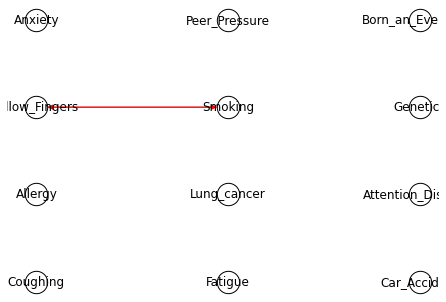

--------Step: 2--------
Total_score:  1219.7716149827288
[[0 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0]]


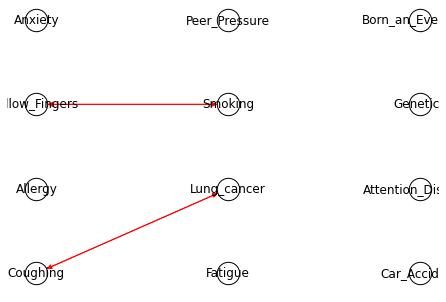

--------Step: 3--------
Total_score:  1492.4115266666768
[[0 1 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0]]


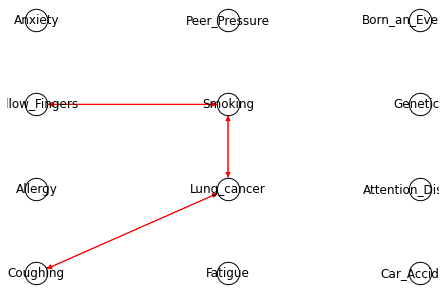

--------Step: 4--------
Total_score:  1729.4401202911158
[[0 1 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0]]


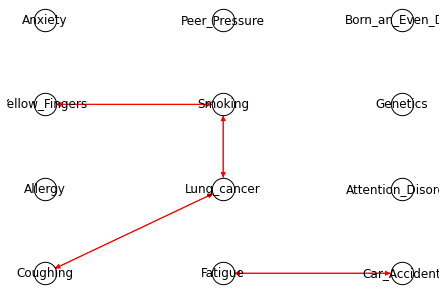

--------Step: 5--------
Total_score:  1963.2106646830935
[[0 1 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0]]


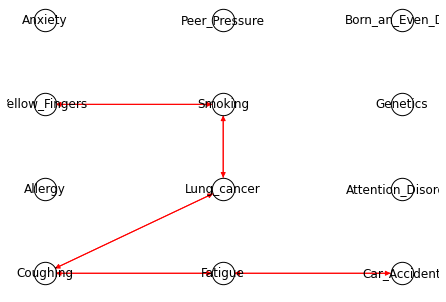

--------Step: 6--------
Total_score:  2134.810274240407
[[0 1 1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0]]


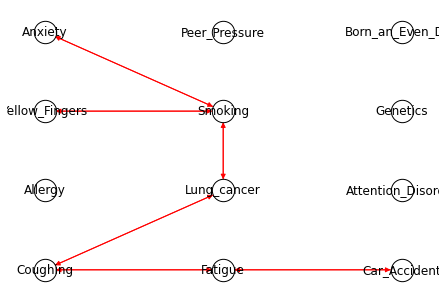

--------Step: 7--------
Total_score:  2281.769878944567
[[0 1 1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0]]


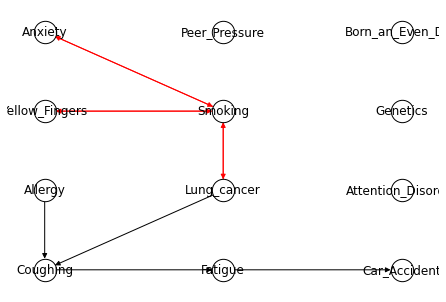

--------Step: 8--------
Total_score:  2389.1590429918383
[[0 1 1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0]]


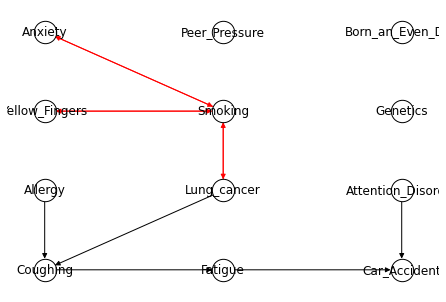

--------Step: 9--------
Total_score:  2460.2800885968136
[[0 1 1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0]]


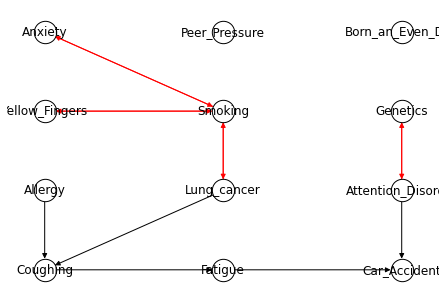

--------Step: 10--------
Total_score:  2524.0482661563065
[[0 1 1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]


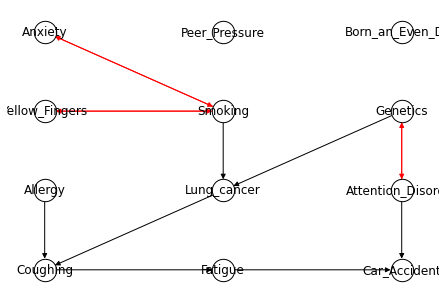

--------Step: 11--------
Total_score:  2550.410282032884
[[0 1 1 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0]]


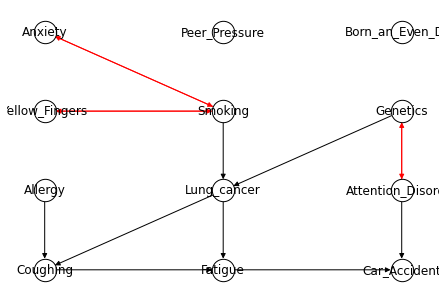

--------Step: 12--------
Total_score:  2573.0381883674772
[[0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0]]


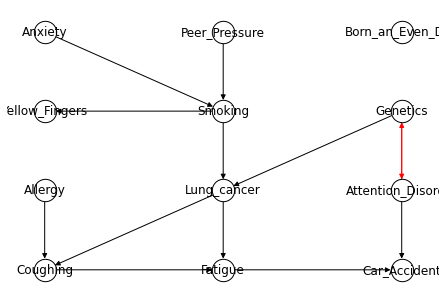

In [24]:
import matplotlib.pyplot as plt
i = 1
print("Total_score: ", 0)
for key, adj in enumerate(inter_adjs):
    fig = plt.figure(i)   
    print("--------Step: {}--------".format(i))
    print("Total_score: ", inter_scores[key])
    _ = draw_from_adj(adj)
    display(fig)
    i += 1
    plt.close()

The GES implementation in DoWhy is wrapper for the GES package, which you can call as follows. Note that we need a DAG for DoWhy to do further estimation.

[[0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0]]


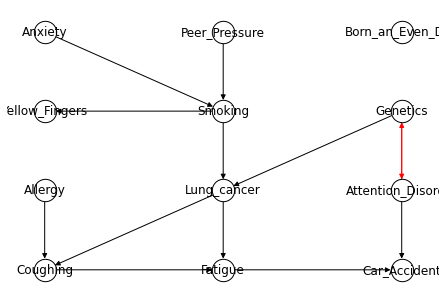

In [25]:
from dowhy.graph_learners.ges import GES

learner = GES(df, 'ges')
_ = learner.learn_graph()
adj = learner._adjacency_matrix
G = draw_from_adj(adj)